In [141]:
"""
Created on Thu Apr 13 10:08:24 2017
@author: kevin
Adapted 2017-05-08 as inspired by:
http://stackoverflow.com/questions/6862770/python-3-let-json-object-accept-bytes-or-let-urlopen-output-strings
"""

from urllib import urlopen 
import json
import codecs
import pymongo
'''Get the records from fda'''
def getRecords(num_records = 100, start_date='20120101', end_date='20161231'):
    reader = codecs.getreader('utf-8')
    #num_records = 4587015
    records = []
    i = 0
    while i in range(0,num_records):#go through all records
        i+=100
        #i = i%5000#limit for skip, as per FDA api
        url = "https://api.fda.gov/drug/event.json?api_key=QIYs3xaRHyjYEkcprTinxbS6QXABp4cu55ZcR2iV&search=receivedate:[" + str(start_date) + "+TO+" + str(end_date) + "]&limit=100" + "&skip=" + str(i)
        response = urlopen(url)
        data = json.load(reader(response))
        print(i)
        results = data["results"]
        records.extend(results)
    '''
    #save data
    with open('drug_adverse_events.json', 'w') as outfile:
        json.dump(records, outfile)
        
    for record in records:
        print record["transmissiondate"]
    '''
    return records

In [142]:
'''sanity check'''
record = getRecords(num_records=100, start_date='20120101', end_date='20161231')

100


In [143]:
def get_recursively(search_dict, field):
    """Takes a dict with nested lists and dicts,
    and searches all dicts for a key of the field
    provided.
    """
    fields_found = []

    for key, value in search_dict.iteritems():

        if key == field:
            fields_found.append(value)

        elif isinstance(value, dict):
            results = get_recursively(value, field)
            for result in results:
                fields_found.append(result)

        elif isinstance(value, list):
            for item in value:
                if isinstance(item, dict):
                    more_results = get_recursively(item, field)
                    for another_result in more_results:
                        fields_found.append(another_result)
    #we want to return a list of values, and we do not want to try and iterate over some none type
    
    new_field_found = []
    if type(fields_found) == list:
        for sublist in fields_found:
            if type(sublist) == list:
                for val in sublist:
                    new_field_found.append(convert_to_float(val))#also convert to float
            else:
                new_field_found.append(convert_to_float(sublist))#also convert to float
    return list(set(new_field_found))

#This gives us the keys using the dot notation. It also gives us an empty 
#string if we dont find the key. It also checks if the next value is inside of a list.
#Some work needs to be done on this. I am not keeping the structure. We dont need
#the structure to stay the same
#TODO:
#    We need to make sure that we can go in through an arbitrary number of lists.
#    It works for an arbitrary number of dicts.
#'''

In [144]:
def getNessessaryKeyValues(record):
    fields = ['safetyreportid',
            'receivedate',
            'serious',
            'seriousnessdeath',
            'seriousnessdisabling',
            'seriousnesshospitalization',
            'seriousnesslifethreatening',
            'seriousnessother',
            'transmissiondate',
            'duplicate',
            'companynumb',
            'occurcountry',
            'primarysourcecountry',
            #'primarysource',
            'qualification',
            'reportercountry',
            #'reportduplicate',
            'duplicatesource',
            'duplicatenumb',
            "patientonsetage",
            "patientonsetageunit",
            "patientsex",
            #"patient.patientweight",#interseting, this data may be useful but is not recorded much
            "patientdeath",
            "patientdeathdate",
            "actiondrug",
            #"patient.drug.drugadditional",
            #"patient.drug.drugcumulativedosagenumb",
            #"patient.drug.drugcumulativedosageunit",
            "drugdosageform",
            #"patient.drug.drugintervaldosagedefinition",
            #"patient.drug.drugrecurreadministration",
            #"patient.drug.drugseparatedosagenumb",
            "drugadministrationroute",
            "drugcharacterization",
            "drugdosagetext",
            'drugenddate',#sometimes patients do not have an end date? maybe replace with some value like -1
            'drugindication',
            'drugstartdate',
            #'patient.drug.drugtreatmentduration',
            #'patient.drug.drugtreatmentdurationunit',
            'medicinalproduct',
            'brand_name',
            'generic_name',
            'manufacturer_name',
            'nui',
            'package_ndc',
            'pharm_class_cs',
            'pharm_class_epc',
            'pharm_class_pe',
            'pharm_class_moa',
            'product_ndc',
            'rxcui',
            'substance_name',
            'reactionmeddrapt',
            'reactionmeddraversionpt',
            'reactionoutcome'
            ]
    subrecord = {}
    for f in fields:
        extracted_record = get_recursively(record, f)
        #we get the key and try to convert to float, otherwise return the same val
        s_record = {}
        if not extracted_record:
            s_record[f] = None
        elif(len(extracted_record) < 2):#if the result is just 1 value, then return that value not a list
            s_record[f] = extracted_record[0]
        else:
            s_record[f] = extracted_record
        subrecord.update(s_record)
    return subrecord


In [145]:
def convert_to_float(s):
    try:
        return float(s)
    except ValueError:
        return s
    except TypeError:
        return s

In [146]:
import pandas as pd

subrecords = []#Get all the records and pull out the stuff we need
for recor in record:
    subrecords.append(getNessessaryKeyValues(recor))
#del records#save memory
#del record

x_y_dataframe = pd.DataFrame(subrecords)
#x_y_dataframe.dropna(how='any')#here we can drop a row if there is any na
#del subrecords

#x_y_dataframe2 = x_y_dataframe.dropna(axis=0)
#get labels
#(x,y) = get_y_vals(x_y_dataframe, 'serious')
#del x_y_dataframe


In [196]:
'''Retrieve data_cols (variables) that are complete - additional variables can be added to this list'''
#x_y_dataframe.columns
#only looked at complete records with columns in data_cols. New dataframe = df_notnan
#'patientdeath', 'seriousnessdeath', 'seriousnessdisabling','seriousnesshospitalization', 'seriousnesslifethreatening','seriousnessother'
data_cols = ['patientonsetage','safetyreportid','serious','occurcountry','patientsex','pharm_class_epc','reactionmeddrapt','reactionoutcome','qualification']
df_notnan = x_y_dataframe[data_cols].dropna()
df_notnan['patientsex'][df_notnan['patientsex'] == 1.0] = 'Male'
df_notnan['patientsex'][df_notnan['patientsex'] == 2.0] = 'Female'
#df_notnan


In [105]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools import plotting
import requests
#import seaborn as sns
import numpy as np
from sklearn import preprocessing
%matplotlib inline  
import seaborn as sns

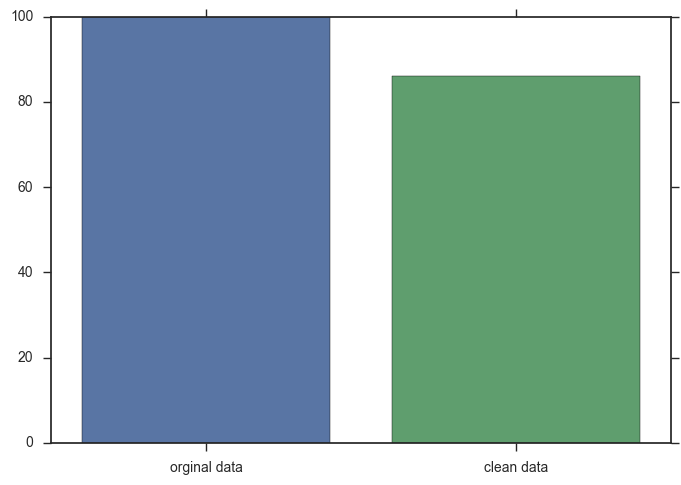

In [151]:
x = ['orginal data', 'clean data']
y= [len(record), len(df_notnan)]
ax = sns.barplot(x, y)

In [152]:
'''Boxplot function - df = dataframe'''
def show_boxplot(df,x,y,color):
    sns.set(style="ticks")
    sns.boxplot(x=x, y=y, hue=color, data=df, palette="PRGn")
    #sns.boxplot(x=x, y=y, hue=color, data=df_notnan, palette="PRGn")
    sns.despine(offset=10, trim=True)
    sns.plt.show()

In [140]:
'''Count reactions for each patient - created 2 new columns(dict/series)'''
df_notnan['reactionmed_count'] = df_notnan['reactionmeddrapt'].apply(lambda x: len(x) if isinstance(x,list) else 1)
df_notnan['reactionoutcomereal'] = df_notnan['reactionoutcome'].apply(lambda x: x[0] if isinstance(x,list) else x)
df_notnan['pharmclass_count'] = df_notnan['pharm_class_epc'].apply(lambda x: len(x) if isinstance(x,list) else 1)
#df_notnan['qualification_count'] = df_notnan['qualification'].apply(lambda x: len(x) if isinstance(x,list) else 1)
#df_notnan

In [195]:
'''Extract Ontology URLs and insert them into dataframe for each patient id'''
def extract_SNOMEID(url):
    return url.split('/')[-1]

def pull_url(field):
    URL = 'https://data.bioontology.org/annotator'
    
    data = {
    'apikey': '1aa5877a-b18b-43a2-bf2d-15a2637638f8',
    'text': field,
    'longest_only': False,
    'whole_word_only': True,
    'exclude_numbers': False,
    'exclude_synonyms': False,
    'ontologies': 'SNOMEDCT'
    }
    annotated = json.loads(requests.post(URL, data=data).text)
    #print('\n')
    #print(field)
    #print(annotated[0])
    url = annotated[0]['annotatedClass']['@id']
    return url

df_notnan['ontology'] = np.nan
df_notnan['ontology'] = df_notnan['ontology'].astype('object')

for i,row in df_notnan.iterrows():
    data = row['reactionmeddrapt']
    #print(data)
    if isinstance(data,list):
        urls= []
        smeids = []
        for check in data:
            #print('LIST\n')
            url = pull_url(check)
            urls.append(url)
            smeid = extract_SNOMEID(url.encode('utf8'))
            smeids.append(smeid)

        df_notnan.set_value(i,'ontology',smeids)
        #df_notnan.set_value(i,'url',url)#can remove....this may not be needed(takes way too long to get)
    else:
        #print('NOT LIST\n')
        #print(data)
        url = pull_url(data)
        smeid = extract_SNOMEID(url.encode('utf8'))
        df_notnan.set_value(i,'ontology',smeid)
        #df_notnan.set_value(i,'url',url)#can remove...this may may not be needed (takes way too long to get)
            
            
#df_notnan         

In [160]:
'''iterate through rows regardless to retrieve all reactions (list or element) and associated age and gender
into new dataframe (df2)'''
age = []
sex = []
reactions = []
qualification = []
serious = []
for i,row in df_notnan.iterrows():
    rr = row['reactionmeddrapt']
    s = row['patientsex']
    a = row['patientonsetage']
    q = row['qualification']
    ser = row['serious']
    #if row['reactionmed_count']>1:
    if isinstance(rr,list) and len(rr)>1 and len(rr[0])>1:
        reactions+=rr
        for j in range(len(rr)):
            sex.append(s)
            age.append(a)
            qualification.append(q)
            serious.append(ser)
    else:
        reactions.append(rr)
        sex.append(s)
        age.append(a)
        qualification.append(q)
        serious.append(ser)
#df2 = pd.DataFrame([age,sex,reactions],columns=['age','sex','reactions'])
df2 = pd.DataFrame({'age':age,'sex':sex,'reactions':reactions, 'qualification':qualification, 'serious': serious})
#[len(age), len(sex),len(reactions)]

    
    

In [114]:
'''Statistical Significance Test - TTest'''
groups = df_notnan.groupby('serious')
for groupname,groupval in groups:
    data1 = groupval['patientonsetage'][groupval['patientsex']=='Male']
    data2 = groupval['patientonsetage'][groupval['patientsex']=='Female']
    print(groupname)
    print(stats.ttest_ind(data1, data2))
    

1.0
Ttest_indResult(statistic=1.0723691492927119, pvalue=0.30875112142331146)
2.0
Ttest_indResult(statistic=-0.49357933837942836, pvalue=0.62310557821988688)


In [115]:
'''Statistical Significance Test - TTest'''
groups = df_notnan.groupby('patientsex')
for groupname,groupval in groups:
    data1 = groupval['patientonsetage'][groupval['serious']==1]
    data2 = groupval['patientonsetage'][groupval['serious']==2]
    print(groupname)
    print(stats.ttest_ind(data1, data2))

Female
Ttest_indResult(statistic=-2.4749731816788745, pvalue=0.015941743553631843)
Male
Ttest_indResult(statistic=0.38176686049878444, pvalue=0.70736423318801234)


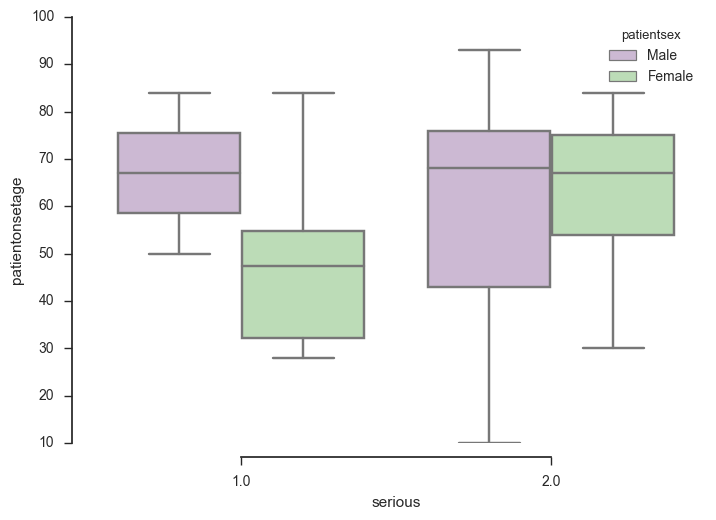

In [116]:
show_boxplot(df_notnan,"serious","patientonsetage","patientsex")

In [194]:
'''Top reactions'''
from collections import Counter
top5 = Counter(df2['reactions']).most_common(5)
total_count= Counter(df2['reactions'])
#top5
#sum(total_count.values())

In [119]:
total_count.keys()

[u'Alanine aminotransferase increased',
 u'Back disorder',
 u'Thirst',
 u'Visual acuity reduced',
 u'Peripheral swelling',
 u'Middle insomnia',
 u'Fluid overload',
 u'Cardiac failure congestive',
 u'Visual impairment',
 u'Tooth extraction',
 u'Asthenia',
 u'Vomiting',
 u'Maternal exposure during pregnancy',
 u'Infusion site infection',
 u'Malaise',
 u'Loss of consciousness',
 u'Vein disorder',
 u'Hypotension',
 u'Dyspepsia',
 u'Off label use',
 u'Arthralgia',
 u'Ileus paralytic',
 u'Weight increased',
 u'Diarrhoea',
 u'Pyelonephritis',
 u'Cough',
 u'Drug ineffective',
 u'Sleep disorder',
 u'Drug intolerance',
 u'Swelling',
 u'Anaemia',
 u'Blood pressure decreased',
 u'Epistaxis',
 u'Tooth disorder',
 u'Rash',
 u'Throat irritation',
 u'Headache',
 u'Tinnitus',
 u'Aspartate aminotransferase increased',
 u'Back pain',
 u'Insomnia',
 u'Abdominal discomfort',
 u'Chest discomfort',
 u'Wrist fracture',
 u'Blood glucose increased',
 u'Nasopharyngitis',
 u'Ear infection',
 u'Pain',
 u'Nasal con

In [197]:
'''top5 = Counter(df2['reactions']).most_common(5)
total_count= Counter(df2['reactions'])
top5'''
topreact = []
topreact_count = []
totalcount = sum(total_count.values())
for val in top5:
    topreact.append(val[0])
    topreact_count.append(val[1]/float(totalcount)*100)
'''x = topreact
y= topreact_count
ax = sns.barplot(x, y)'''

'x = topreact\ny= topreact_count\nax = sns.barplot(x, y)'

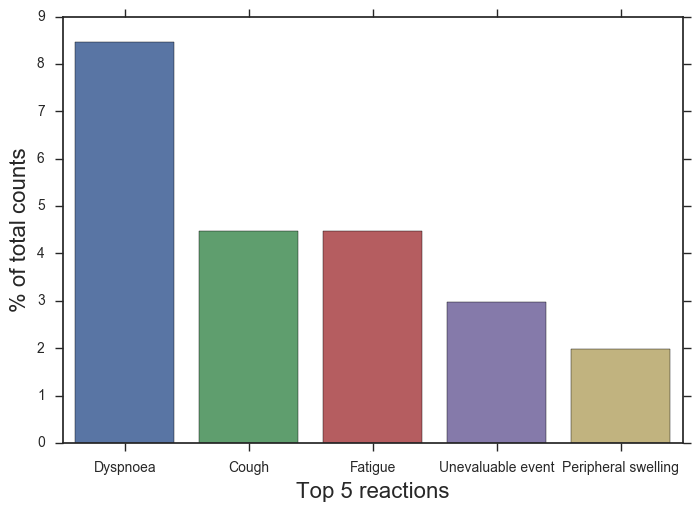

In [199]:
x = topreact
y= topreact_count
ax = sns.barplot(x, y)
ax.set_ylabel('% of total counts',fontsize=16)
ax.set_xlabel('Top 5 reactions',fontsize=16)

In [161]:
df2

,age,qualification,reactions,serious,sex
0,78.0,5.0,Chemotherapy,2.0,Male
1,78.0,5.0,Middle insomnia,2.0,Male
2,78.0,5.0,Dyspnoea,2.0,Male
3,31.0,1.0,Sinusitis,2.0,Female
4,86.0,5.0,Weight decreased,2.0,Male
5,86.0,5.0,Oedema,2.0,Male
6,67.0,5.0,Asthenia,2.0,Female
7,67.0,5.0,Tooth disorder,2.0,Female
8,67.0,5.0,Anaemia,2.0,Female
9,47.0,1.0,Abdominal pain,1.0,Female


In [130]:
top5 = [x for x,y in Counter(df2['reactions']).most_common(5)]; top5
df2_top5 = df2[df2['reactions'].isin(top5)]

In [136]:
'''Statistical Significance Test - TTest'''
groups = df2_top5.groupby('reactions')
for groupname,groupval in groups:
    data1 = groupval['age'][groupval['sex']=='Male']
    data2 = groupval['age'][groupval['sex']=='Female']
    print(groupname)
    print(stats.ttest_ind(data1, data2))

Cough
Ttest_indResult(statistic=0.30579109143745486, pvalue=0.76865732154944033)
Dyspnoea
Ttest_indResult(statistic=1.4922864258737949, pvalue=0.15635600313985207)
Fatigue
Ttest_indResult(statistic=-5.4641616288479469, pvalue=0.00094168989431237362)
Peripheral swelling
Ttest_indResult(statistic=nan, pvalue=nan)
Unevaluable event
Ttest_indResult(statistic=1.1129968440857017, pvalue=0.32808361851481788)


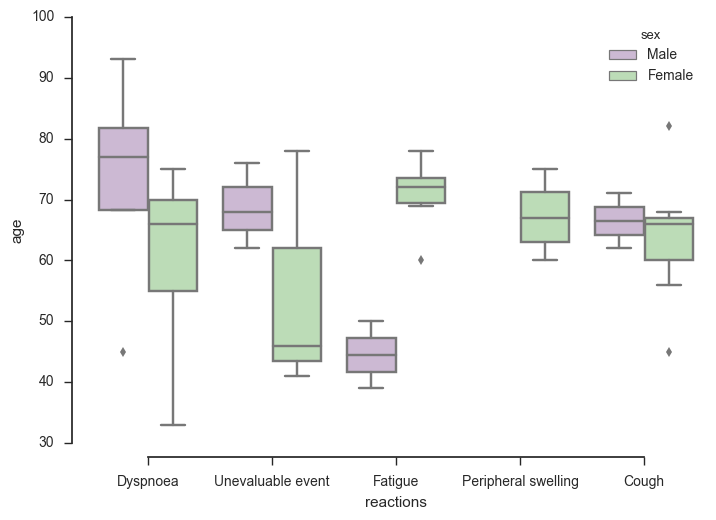

In [132]:
'''Age and Sex grouped by Reactions'''
top5 = [x for x,y in Counter(df2['reactions']).most_common(5)]; top5

show_boxplot(df2_top5,"reactions","age","sex")



{u'FR': 1, u'ES': 1, u'US': 80, u'CN': 4}


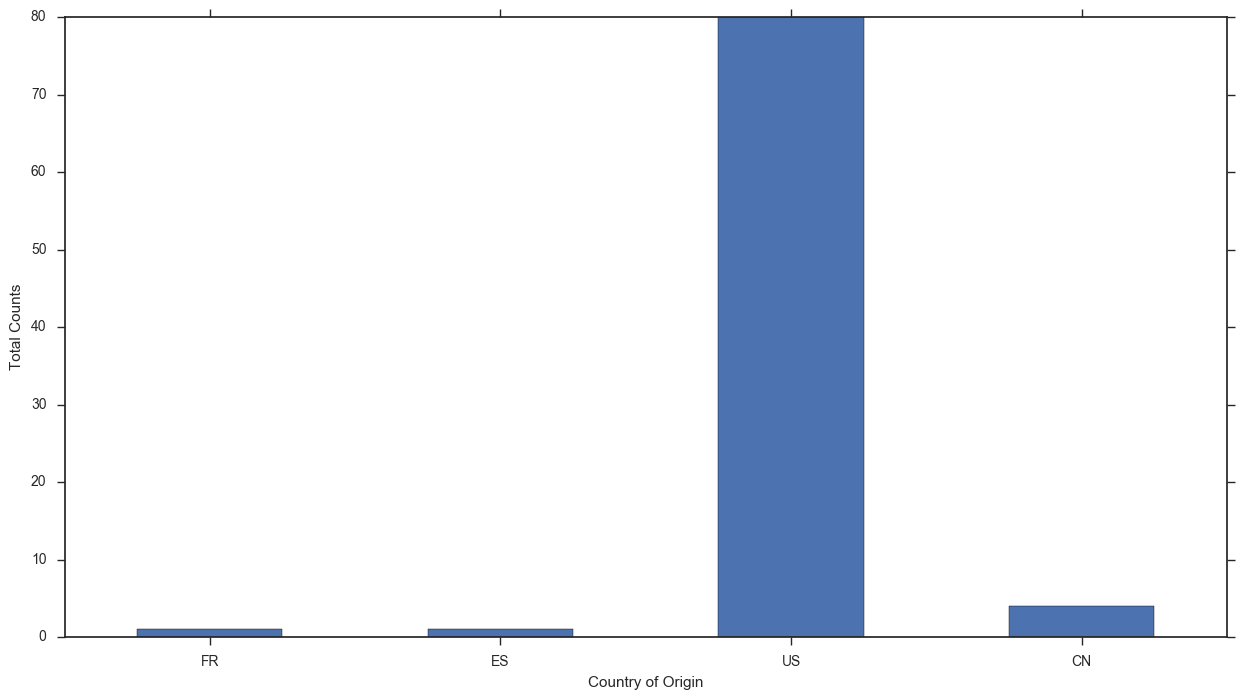

In [34]:
countrycounts = {}
fig,ax = plt.subplots(figsize=(15,8))
for row in df_notnan.itertuples():
    country = row.occurcountry
    countrycount = countrycounts.get(country, 0)
    countrycounts[country]=countrycount+1
print countrycounts
xlocations = np.array(range(len(countrycounts)))
width = 0.5
ax.bar(xlocations, countrycounts.values(), width=width, align = 'center')
plt.xticks(range(len(countrycounts)),countrycounts.keys())
plt.xlabel('Country of Origin')
plt.ylabel('Total Counts')

In [123]:
'''Statistical Significance Test - TTest'''
groups = df_notnan.groupby('occurcountry')
for groupname,groupval in groups:
    data1 = groupval['patientonsetage'][groupval['patientsex']=='Male']
    data2 = groupval['patientonsetage'][groupval['patientsex']=='Female']
    print(groupname)
    print(stats.ttest_ind(data1, data2))

CN
Ttest_indResult(statistic=nan, pvalue=nan)
ES
Ttest_indResult(statistic=nan, pvalue=nan)
FR
Ttest_indResult(statistic=nan, pvalue=nan)
US
Ttest_indResult(statistic=-0.33026823512070613, pvalue=0.7420827322724981)


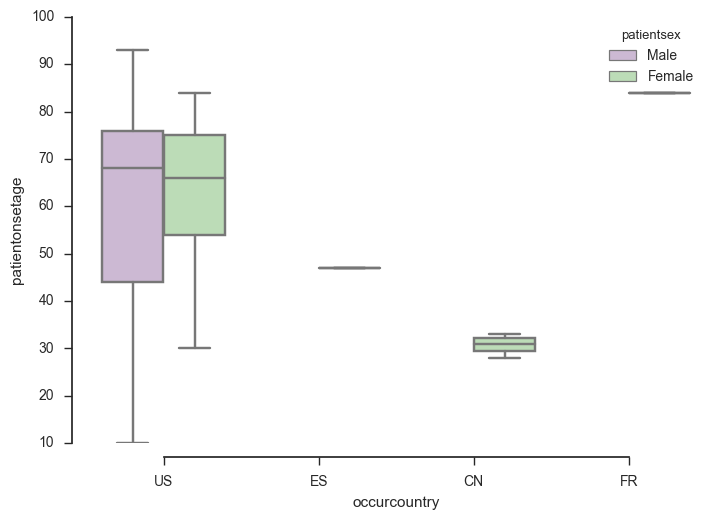

In [36]:
show_boxplot(df_notnan, "occurcountry","patientonsetage","patientsex")

<type 'numpy.float64'>
<type 'numpy.float64'>


''

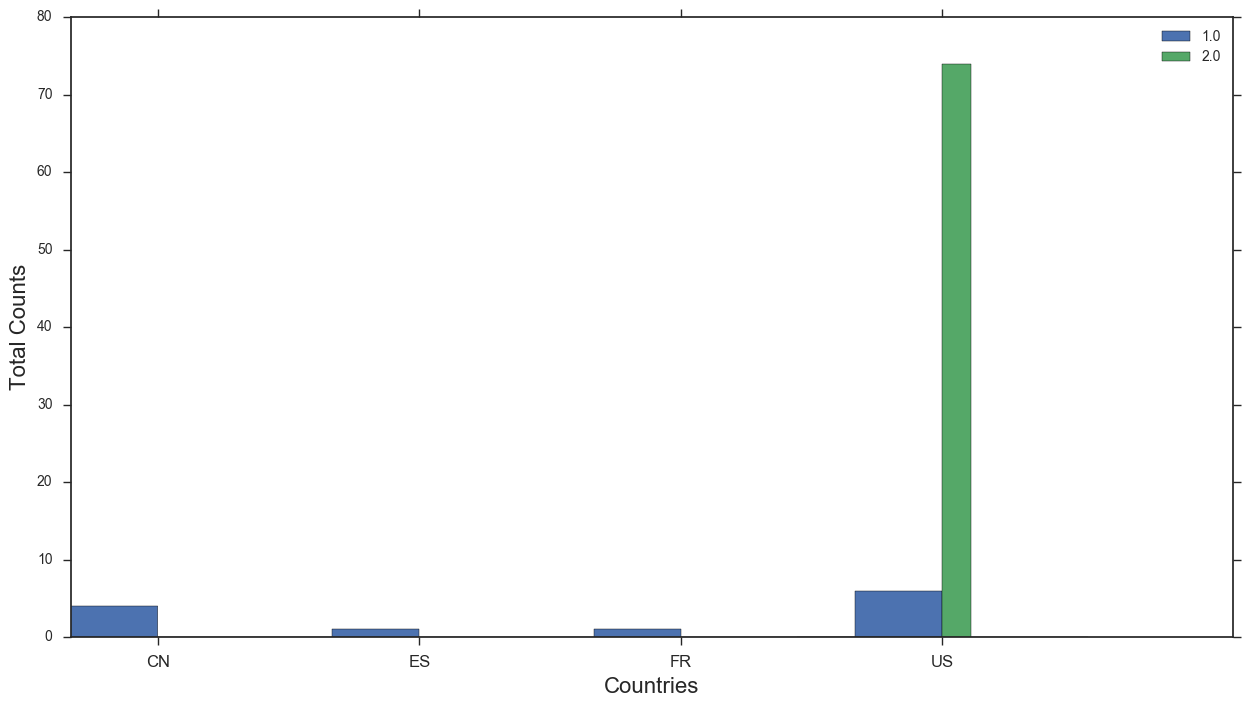

In [200]:
'''Group Histogram - Serious Vs Country'''

#x,y,z = np.unique(df_notnan['occurcountry'],return_inverse=True,return_counts=True) #https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.unique.html
#df_notnan['occurcountry'].value_counts()
#df_notnan['occurcountry'][y==3]
'''transform non-numerical labels '''
le = preprocessing.LabelEncoder()
df_notnan['occurcountry_num'] = le.fit_transform(df_notnan['occurcountry'])
df_notnan['patientsex_num'] = le.fit_transform(df_notnan['patientsex'])

groups = df_notnan.groupby(['serious'])
fig,ax = plt.subplots(figsize=(15,8))
axs = []
for groupname,groupval in groups:
    #sns.distplot(groupval['occurcountry_num'], kde=False)
    print(type(groupname))
    a = ax.hist(groupval['occurcountry_num'],label=str(groupname))
    #a = ax.bar(groupval['occurcountry_num'].value_counts(),align='center')
    axs.append(a)
    #print(groupval['occurcountry_num'])
ax.set_xlabel('Countries',fontsize=16)
ax.set_ylabel('Total Counts',fontsize=16)
ax.set_xticks([0.3,1.2,2.1,3]) #Play with these to line up the ticks with the bars
ax.set_xticklabels(np.unique(df_notnan['occurcountry']),fontsize=12)
#ax.legend(axs,np.unique(df_notnan['serious']))
ax.legend()
''''''

In [ ]:
'''Calculate the top 5 most common reactions'''
top5 = [x for x,y in Counter(df2['reaction']).most_common(5)]; top5
df2_top5 = df2[df2['reactions'].isin(top5)]

In [193]:
'''Calculate the qualification and serious events'''
qual = Counter(df2['qualification'])
ser = Counter(df2['serious'])
tot_qual = sum(Counter(df2['qualification']).values())
tot_ser = sum(Counter(df2['serious']).values())


In [186]:
qual_list = []
qual_count = []
ser_list = []
for key,value in qual.items():
    qual_list.append(key)
    qual_count.append(value/float(tot_qual)*100)

In [190]:
ser_count = []
ser_list = []
for key,value in ser.items():
    ser_list.append(key)
    ser_count.append(value/float(tot_qual)*100)

'1 = Physician\n2 = Pharmacist\n3 = Other health professional\n4 = Lawyer\n5 = Consumer or non-health professional'

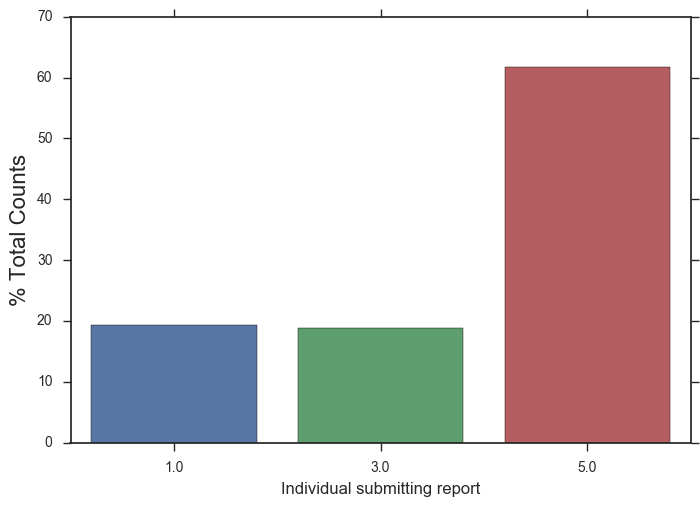

In [206]:

x = qual_list
y1= qual_count
#y2 = 
ax = sns.barplot(x, y1)
ax.set_xlabel('Individual submitting report',fontsize=12)
ax.set_ylabel('% Total Counts',fontsize=16)
'''1 = Physician
2 = Pharmacist
3 = Other health professional
4 = Lawyer
5 = Consumer or non-health professional'''

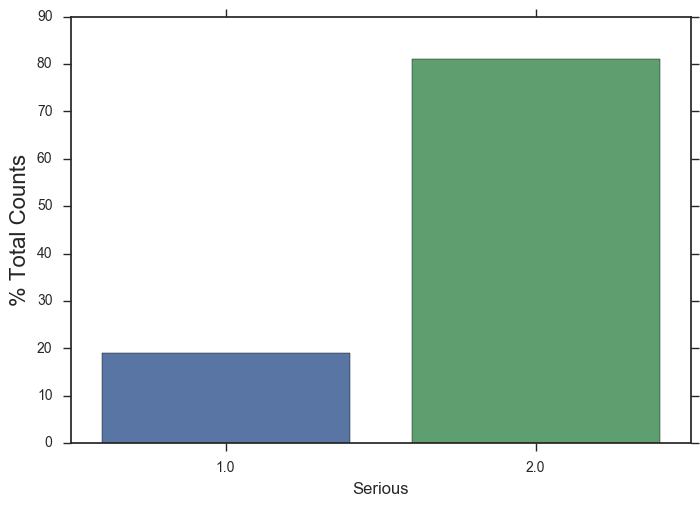

In [207]:
'''Total serious events'''
x = ser_list
y1= ser_count
#y2 = 
ax = sns.barplot(x, y1)
ax.set_xlabel('Serious',fontsize=12)
ax.set_ylabel('% Total Counts',fontsize=16)

In [6]:

def get_dotted(d, keys):
    if "." in keys:
        key, rest = keys.split(".", 1)
        if type(d) == list:#make sure its not a list
            d = d[0]
        if type(d[key]) != list and type(d[key]) != dict:#make sure its either a dict or list, otherwise return empty
            if keys not in d:
                d[keys] = None#some empty value
            return {rest: d[key]}
        return get_dotted(d[key], rest)
    else:
        if type(d) == list:#make sure its not a list
            d = d[0]
        if keys not in d:
            d[keys] = None#some empty value
        
        subDic = {keys: d[keys]}
        return subDic

In [21]:
def get_y_vals(df, y_label):
    #df.loc[pandas.isnull(df[y_label])] = ""#missing data
    #df.loc[df[y_label].str.contains("", na=False)] = 0
    y = df[y_label]
    del df[y_label]
    return (df, y)#return the new dataframe and y array

'''
Returns a trained naive_bays model
'''

'\nReturns a trained naive_bays model\n'

In [ ]:
def naive_bays(x_train, y_train, bagging = False, boosting = False):
    from sklearn.naive_bayes import GaussianNB as NB
    nb = NB()
    if bagging == True and boosting == True:
        raise ValueError("Cant have bagging and boosting enabled at the same time")
    if bagging == True:#if bagging
        from sklearn.ensemble import BaggingClassifier
        model = BaggingClassifier (nb, max_samples=.5, max_features=.5)
    elif boosting == True:
        from sklearn.ensemble import AdaBoostClassifier
        model = AdaBoostClassifier(nb,
                         algorithm="SAMME",
                         n_estimators=300)
    else:#just regular logistic regression
        model = nb
    model.fit(x_train, y_train)
    return model
'''
Returns a trained logistic regression model
'''

In [ ]:
def logistic_regression(x_train, y_train, bagging = False, boosting = False):
    from sklearn import linear_model
    lr = linear_model.LogisticRegression()
    if bagging == True and boosting == True:
        raise ValueError("Cant have bagging and boosting enabled at the same time")
    if bagging == True:#if bagging
        from sklearn.ensemble import BaggingClassifier
        model = BaggingClassifier (lr, max_samples=.5, max_features=.5)
    elif boosting == True:
        from sklearn.ensemble import AdaBoostClassifier
        model = AdaBoostClassifier(lr,
                         algorithm="SAMME",
                         n_estimators=300)
    else:#just regular logistic regression
        model = lr
    model.fit(x_train, y_train)
    return model

In [ ]:

def random_forest(x_train, y_train, estimators = 100, maxDepth = None, randomState = 10, maxFeatures = 'auto'):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=estimators, max_depth=maxDepth,
                           random_state=randomState, max_features=maxFeatures)
    model.fit(x_train, y_train)
    return model

'''
split arrays into evenly sized chunks
'''

In [ ]:
def chunks(array, n):
    """Yield successive n-sized chunks from array."""
    for i in xrange(0, len(array), n):
        yield array[i:i + n]

In [ ]:
#Auto encodes any dataframe column of type category or object.
def dummyEncode(df):
    from sklearn.preprocessing import LabelEncoder
    columnsToEncode = list(df.select_dtypes(include=['category','object']))
    le = LabelEncoder()
    for feature in columnsToEncode:
        try:
            df[feature] = le.fit_transform(df[feature])
        except:
            print('Error encoding '+feature)
    return df

In [ ]:
def one_hot_encode(categorical_labels):
    res = []
    tmp = None
    for col in categorical_labels:
        v = x[col].astype(str).str.strip('[]').str.get_dummies(', ')#cant set a prefix
        if len(res) == 2:
            tmp = pandas.concat(res, axis=1)
            del res
            res = []
            res.append(tmp)
            del tmp
            tmp = None
        else:
            res.append(v)
    result = pandas.concat(res, axis=1)
    return result

In [ ]:
if __name__ == '__main__':
    #main method
    records = getRecords(num_records=1000)#get records
    
    #save to disk
    with open('data.json', 'w') as outfile:
        json.dump(records, outfile)
    #read from disk
    with open('data.json') as json_data:
        records = json.load(json_data)
    subrecords = []#Get all the records and pull out the stuff we need
    for record in records:
        subrecords.append(getNessessaryKeyValues(record))
    del records#save memory
    del record
    
    import pandas
    x_y_dataframe = pandas.DataFrame(subrecords)
    #x_y_dataframe.dropna(how='any')#here we can drop a row if there is any na
    del subrecords
    
    #x_y_dataframe2 = x_y_dataframe.dropna(axis=0)
    #get labels
    (x,y) = get_y_vals(x_y_dataframe, 'serious')
    del x_y_dataframe
    #df = pandas.DataFrame([{'drug': ['drugA','drugB'], 'patient': 'john'}, {'drug': ['drugC','drugD'], 'patient': 'angel'}])
    
    categorical_labels = [
 'actiondrug',
 'brand_name',
 'companynumb',
 'drugadministrationroute',
 'drugcharacterization',
 'drugdosageform',
 'drugdosagetext',
 'drugenddate',
 'drugindication',
 'drugstartdate',
 #'duplicate',
 'duplicatenumb',
 'duplicatesource',
 'generic_name',
 'manufacturer_name',
 'medicinalproduct',
 'nui',#has lists
 'occurcountry',
 'package_ndc',
 'patientdeath',
 'patientdeathdate',
 #'patientonsetage',
 'patientonsetageunit',
 'patientsex',
 'pharm_class_cs',
 'pharm_class_epc',
 'pharm_class_moa',
 'pharm_class_pe',
 'primarysourcecountry',
 'product_ndc',
 #'qualification',
 'reactionmeddrapt',
 'reactionmeddraversionpt',
 'reactionoutcome',
 #'receivedate',
 'reportercountry',
 'rxcui',
 #'safetyreportid',
 'seriousnessdeath',
 'seriousnessdisabling',
 'seriousnesshospitalization',
 'seriousnesslifethreatening',
 'seriousnessother',
 'substance_name',
 #'transmissiondate'
 ]
    #save data
    x.to_pickle('x_data.pkl')
    y.to_pickle('y_data.pkl')
    #load data
    import pandas
    x = pandas.read_pickle('x_data.pkl')
    y = pandas.read_pickle('y_data.pkl')
    
    '''
    get difference in labeles we are one-hot encoding and ones we aren't
    We need to preserve the ones we arent one-hot encoding
    '''
    s = set(categorical_labels)
    not_categorical_labels = [x_val for x_val in list(x) if x_val not in s]
    x_non_cat_labels = x[not_categorical_labels]#save non cat to temp var
    
    num_processors = 4
    n_size = int(round(len(categorical_labels)/num_processors))
    import time
    import multiprocessing
    
    start_time = time.time()
    p = multiprocessing.Pool(num_processors)
    res = (p.map(one_hot_encode, list(chunks(categorical_labels, n_size))))
    print (time.time()-start_time)
    p.terminate()#kill the workers
    res.append(x_non_cat_labels)
    del x_non_cat_labels
    x = pandas.concat(res, axis=1)
    y = pandas.to_numeric(y.astype(str).str.strip('[]'))
    x = x.dropna(how='any')
    y = y[x.index]
#    y[y.isnull()] = 0#we do this to convert nans, if its empty, we set it to 0
    #y[0:20] = 1#just a test
#    import numpy as np
#    x[np.isfinite(x['drugintervaldosagedefinition'])]
    #x_y_dataframe.dropna(how='any')#here we can drop a row if there is any na
    #split the data:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    del x, y
    #do a logistic regression
    model = logistic_regression(X_train, list(y_train), bagging=True)
    y_hat = model.predict(X_test)#predict
    y_test = y_test.reset_index(drop=True)    
    from sklearn.metrics import accuracy_score
    accuracy_score(y_test, y_hat)
    
    
    #do a random forest
    model = random_forest(X_train, list(y_train))
    y_hat = model.predict(X_test)#predict
    y_test = y_test.reset_index(drop=True)    
    from sklearn.metrics import accuracy_score
    accuracy_score(y_test, y_hat)
    
    #do a naive bays
    model = naive_bays(X_train, list(y_train), bagging=True)
    y_hat = model.predict(X_test)#predict
    y_test = y_test.reset_index(drop=True)    
    from sklearn.metrics import accuracy_score
    accuracy_score(y_test, y_hat)    
    
    
    collection = startmongodb()#get collection
    collection.count()
    collection.insert_many(subrecords)
    print(collection.find_one())


In [7]:
startmongodb()

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), u'cbb750_final_database'), u'fda_records')

In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-


'''Start mongodb, return the fda_records collection for querying'''
def startmongodb():
    from pymongo import MongoClient
    client = MongoClient()
    db = client.cbb750_final_database
    collection = db['fda_records']
    return collection
#This gives us the required key/vals.
